# Simulate Atmosphere from Merra2 For Article figures

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date 2025-01-11 :
- last update : 2025-02-20
- last update : 2025-04-24 : bug corrected with ChatGPT
- last update : 2025-04-26 : add total transmission
- Kernel @usdf **w_2024_50*
- Office emac : mamba_py311
- Home emac : base (conda)
- laptop : conda_py311

**Goal** : Show how the variation of Merra2 parameter impact the transmission

In [1]:
from platform import python_version
print(python_version())

3.12.9


In [2]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [3]:
from platform import python_version
print(python_version())

3.12.9


In [4]:
import os

In [5]:
# where are stored the figures
pathfigs = "figsSimulateAtmosphereFomMerra2ForArticle"
if not os.path.exists(pathfigs):
    os.makedirs(pathfigs) 
figtype = ".png"

In [6]:
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor="white", alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy import constants as c

from astropy.coordinates.earth import EarthLocation
from datetime import datetime
from pytz import timezone

from scipy import interpolate
#from sklearn.neighbors import NearestNeighbors
#from sklearn.neighbors import KDTree, BallTree

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit,least_squares


# new color correction model
import pickle
from scipy.interpolate import RegularGridInterpolator

In [7]:
# Library to fit atmosphere
import sys
sys.path.append('../../lib')
#import libAtmosphericFit
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


In [8]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [9]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [10]:
# set default photometric parameters to compute ADU
photoparams = set_photometric_parameters(30, 1 , readnoise=None)

In [11]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [12]:
from astropy.modeling import models

In [13]:
from numpy.random import lognormal

In [14]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [15]:
# Remove to run faster the notebook
#import ipywidgets as widgets
#%matplotlib widget

In [16]:
from importlib.metadata import version

In [17]:
# wavelength bin colors
#jet = plt.get_cmap('jet')
#cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [18]:
np.__version__

'2.0.2'

In [19]:
pd.__version__

'2.2.3'

In [20]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [21]:
def pdf_lognormal(x,a0,mu,sigma):
    """
    """
    pdf = a0*(np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/ (x * sigma * np.sqrt(2 * np.pi)))
    return pdf

In [22]:
x = np.linspace(0,15)
y = pdf_lognormal(x,a0=100,mu=1,sigma=0.5)

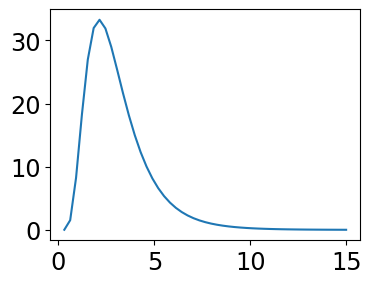

In [23]:
plt.plot(x,y)

## Configuration

In [24]:
# reference flux in Jy
F0 = ((0.*u.ABmag).to(u.Jy)).value
F0

np.float64(3630.7805477010033)

In [25]:
observing_location = EarthLocation.of_site('Rubin Observatory')
tz = timezone('America/Santiago')

In [26]:
am0 = 1.20    # airmass
pwv0 = 4.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.0 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent


In [27]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

Text(0.5, 1.0, 'Standard atmosphere transmission')

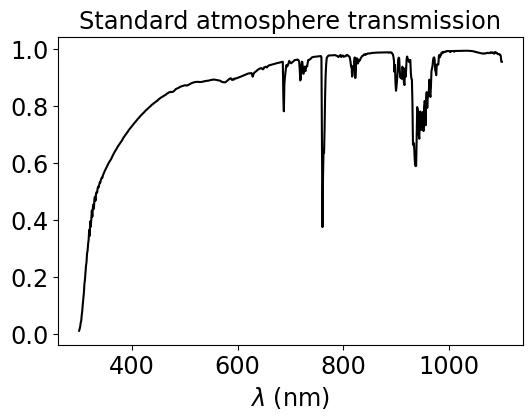

In [28]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

Text(0.5, 1.0, 'Instrument throughput (LSST)')

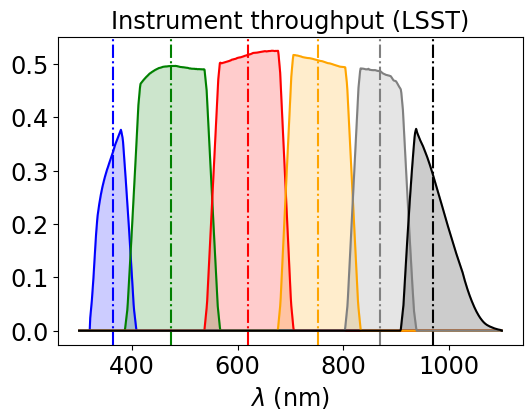

In [29]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (LSST)")


Text(0.5, 1.0, 'Total filter throughput (LSST)')

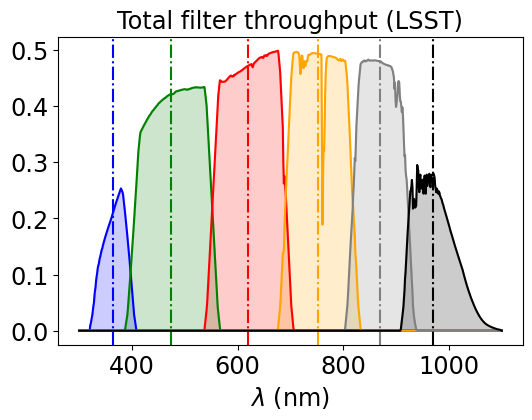

In [30]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (LSST)")


### MERRA2

In [31]:
filename_m2 = "../../SpectroMerra2/MerradataMerged/Merge_inst1_2d_asm_Nx_M2I1NXASM-2021-2024.csv"
filename_m2b = "../../SpectroMerra2/MerradataMerged/Merge_tavg1_2d_aer_Nx_M2T1NXAER-2021-2024.csv"

In [32]:
df_m = pd.read_csv(filename_m2)
df_mb = pd.read_csv(filename_m2b)

In [33]:
df_mb.columns

Index(['Unnamed: 0', 'time', 'TOTANGSTR', 'TOTEXTTAU', 'TOTSCATAU', 'Time'], dtype='object')

In [34]:
TMIN = pd.to_datetime(df_m.time.min())
TMAX = pd.to_datetime(df_m.time.max())

In [35]:
pd.to_datetime(df_m.Time.values)

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2024-12-31 14:00:00', '2024-12-31 15:00:00',
               '2024-12-31 16:00:00', '2024-12-31 17:00:00',
               '2024-12-31 18:00:00', '2024-12-31 19:00:00',
               '2024-12-31 20:00:00', '2024-12-31 21:00:00',
               '2024-12-31 22:00:00', '2024-12-31 23:00:00'],
              dtype='datetime64[ns]', length=32136, freq=None)

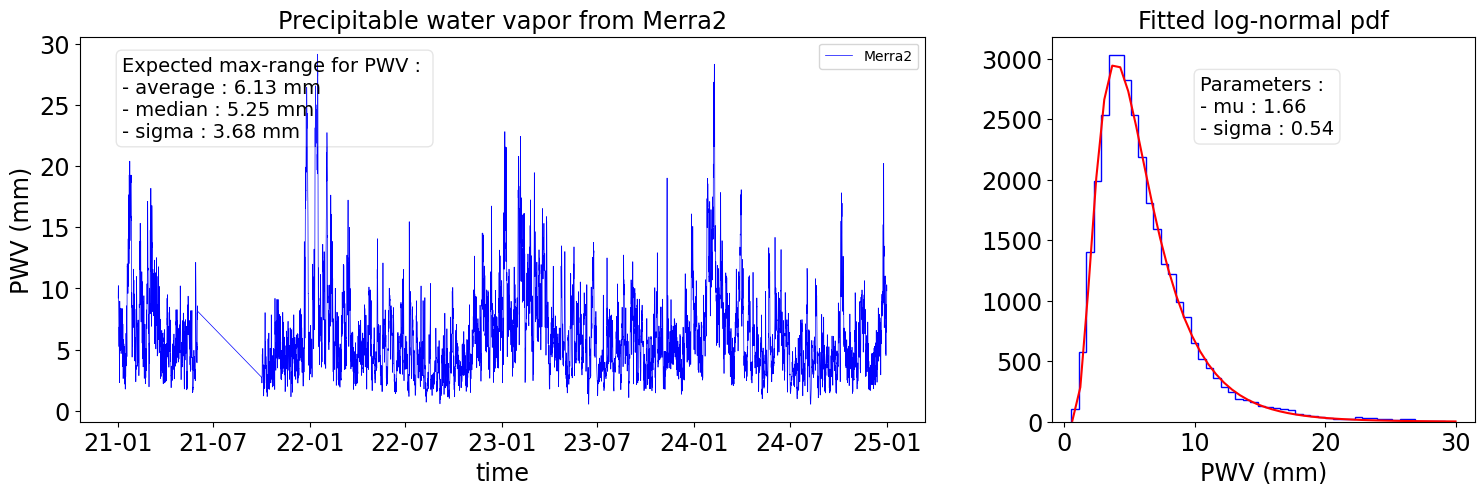

In [36]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m")

fig = plt.figure(figsize=(18,5))
gs = GridSpec(1, 2,  width_ratios=[2,1],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
        
leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.plot(pd.to_datetime(df_m.Time.values), df_m.TQV.values,c="b",lw=0.5,label="Merra2")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title("Precipitable water vapor from Merra2")
ax1.legend()
ax1.set_ylabel("PWV (mm)")
#ax.set_xlim(TMIN,TMAX)

data = df_m.TQV.values
mean = np.mean(data)
median = np.median(data)
std = np.std(data)
textstr = "\n".join((f"Expected max-range for PWV : ",
                     f"- average : {mean:.2f} mm",
                     f"- median : {median:.2f} mm",
                     f"- sigma : {std:.2f} mm",     
                    ))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)

XMIN = 0.
XMAX = 30.
counts,xedges, _ = ax2.hist(df_m.TQV.values,bins=50,histtype="step",color="b",ls="-",lw=3)
xcenters = (xedges[:-1] + xedges[1:]) / 2

xdata = xcenters
ydata = counts

popt, pcov = curve_fit(pdf_lognormal, xdata, ydata, p0 = [100.,1.,0.5])
sigmas = np.diag(pcov)
xfit = np.linspace(XMIN,XMAX,50)
yfit = pdf_lognormal(xfit,*popt)
ax2.plot(xfit,yfit,"-r")
textstr2 = "\n".join((f"Parameters : ",
                     f"- mu : {popt[1]:.2f}",
                     f"- sigma : {popt[2]:.2f}",     
                    ))
ax2.text(0.35, 0.9, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.set_xlabel("PWV (mm)")
ax2.set_title("Fitted log-normal pdf")

figname =f"{pathfigs}/pwv_allpoints_merra2"+figtype
fig.savefig(figname)
plt.show()


In [37]:
data_sim_pwv = np.random.lognormal(popt[1],popt[2],50000)

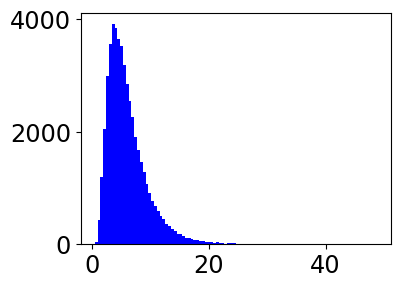

In [38]:
plt.hist(data_sim_pwv,bins=100,facecolor="b");

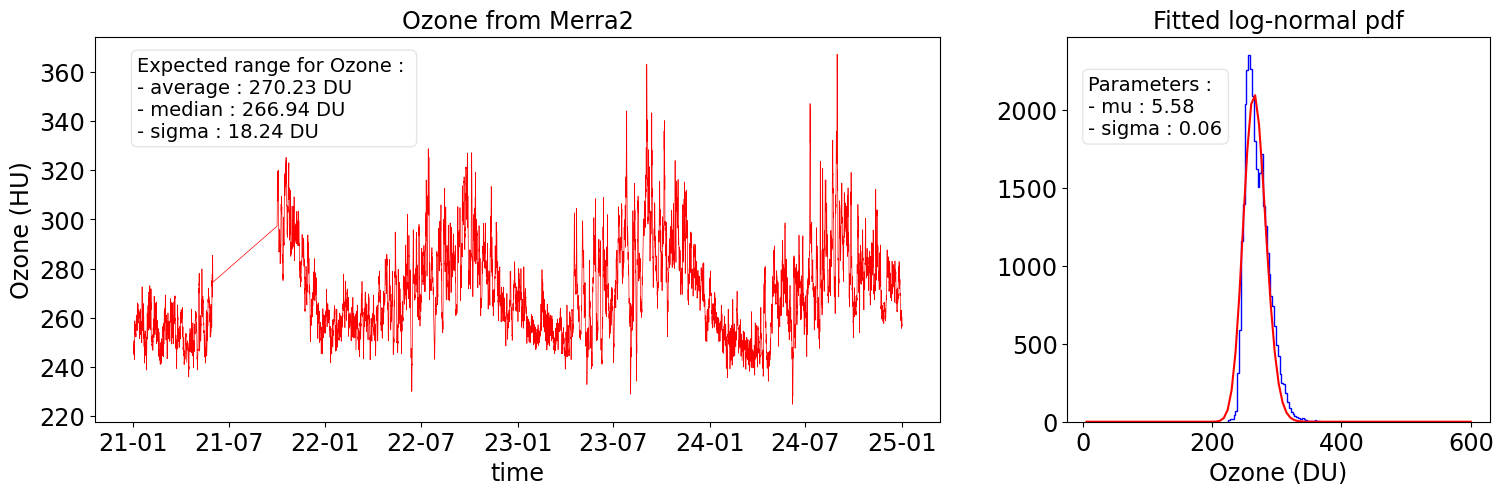

In [39]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m")

fig = plt.figure(figsize=(18,5))
gs = GridSpec(1, 2,  width_ratios=[2,1],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
        
leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.plot(pd.to_datetime(df_m.Time.values), df_m.TO3.values,c="r",lw=0.5,label="Merra2")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title("Ozone from Merra2")
#ax1.legend()
ax1.set_ylabel("Ozone (HU)")
#ax.set_xlim(TMIN,TMAX)

data = df_m.TO3.values
mean = np.mean(data)
median = np.median(data)
std = np.std(data)
textstr = "\n".join((f"Expected range for Ozone : ",
                     f"- average : {mean:.2f} DU",
                     f"- median : {median:.2f} DU",
                     f"- sigma : {std:.2f} DU",     
                    ))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)




XMIN = 0.
XMAX = 600.
counts,xedges, _ = ax2.hist(df_m.TO3.values,bins=50,histtype="step",color="b",ls="-",lw=3)
xcenters = (xedges[:-1] + xedges[1:]) / 2

xdata = xcenters
ydata = counts

popt, pcov = curve_fit(pdf_lognormal, xdata, ydata, p0 = [100.,300.,100])
sigmas = np.diag(pcov)
xfit = np.linspace(XMIN,XMAX,100)
yfit = pdf_lognormal(xfit,*popt)
ax2.plot(xfit,yfit,"-r")
textstr2 = "\n".join((f"Parameters : ",
                     f"- mu : {popt[1]:.2f}",
                     f"- sigma : {popt[2]:.2f}",     
                    ))
ax2.text(0.05, 0.9, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.set_xlabel("Ozone (DU)")
ax2.set_title("Fitted log-normal pdf")


figname =f"{pathfigs}/ozone_allpoints_merra2"+figtype
fig.savefig(figname)
plt.show()


(0.0, 600.0)

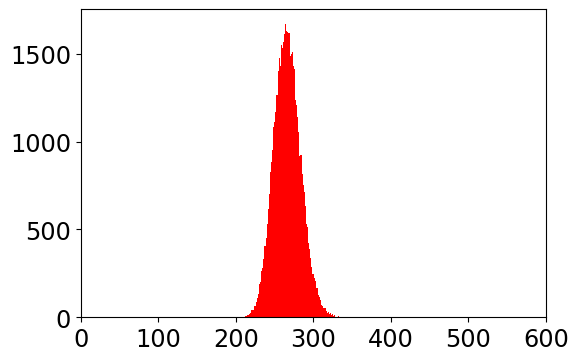

In [40]:
data_sim_o3 = np.random.lognormal(popt[1],popt[2],50000)
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(data_sim_o3,bins=100,facecolor="r");
ax.set_xlim(0.,600.)

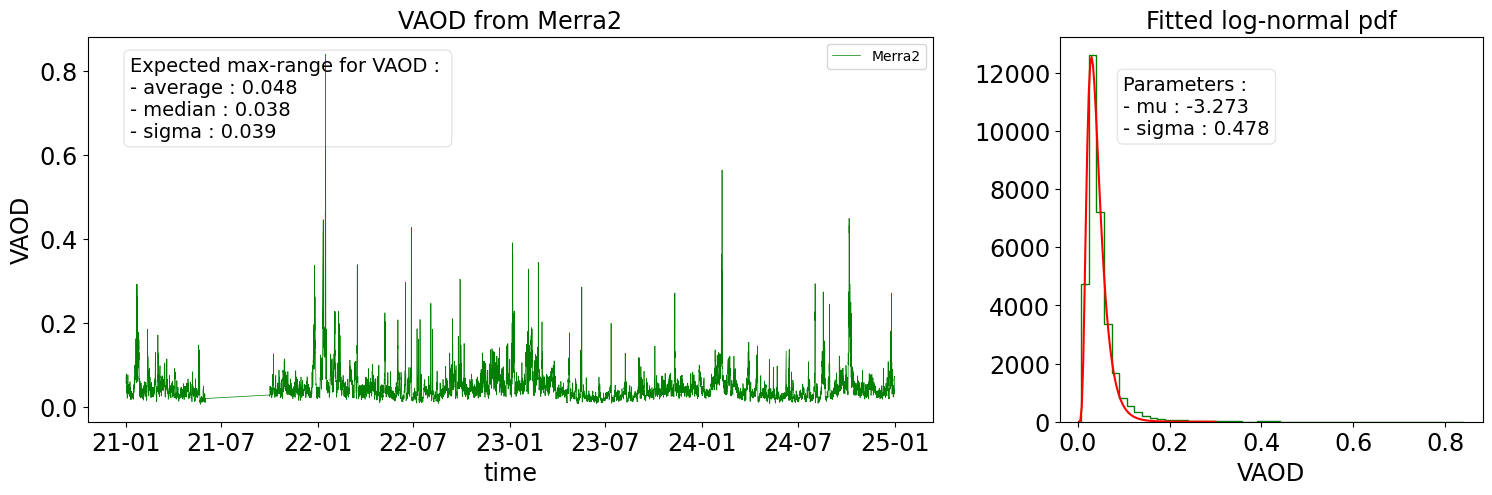

In [41]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m")

fig = plt.figure(figsize=(18,5))
gs = GridSpec(1, 2,  width_ratios=[2,1],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
        
leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.plot(pd.to_datetime(df_mb.Time.values), df_mb.TOTEXTTAU.values,c="g",lw=0.5,label="Merra2")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title("VAOD from Merra2")
ax1.legend()
ax1.set_ylabel("VAOD")
#ax.set_xlim(TMIN,TMAX)
data = df_mb.TOTEXTTAU.values
mean = np.mean(data)
median = np.median(data)
std = np.std(data)
textstr = "\n".join((f"Expected max-range for VAOD : ",
                     f"- average : {mean:.3f}",
                     f"- median : {median:.3f}",
                     f"- sigma : {std:.3f}",     
                    ))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)


XMIN = 0.
XMAX = 0.3
counts,xedges, _ = ax2.hist(df_mb.TOTEXTTAU.values,bins=50,histtype="step",color="g",ls="-",lw=3)
xcenters = (xedges[:-1] + xedges[1:]) / 2

xdata = xcenters
ydata = counts

popt, pcov = curve_fit(pdf_lognormal, xdata, ydata, p0 = [100.,1.,0.5])
sigmas = np.diag(pcov)
xfit = np.linspace(XMIN,XMAX,100)
yfit = pdf_lognormal(xfit,*popt)
ax2.plot(xfit,yfit,"-r")
textstr2 = "\n".join((f"Parameters : ",
                     f"- mu : {popt[1]:.3f}",
                     f"- sigma : {popt[2]:.3f}",     
                    ))
ax2.text(0.15, 0.9, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.set_xlabel("VAOD")
ax2.set_title("Fitted log-normal pdf")


figname =f"{pathfigs}/vaod_allpoints_merra2"+figtype
fig.savefig(figname)
plt.show()


(0.0, 1.0)

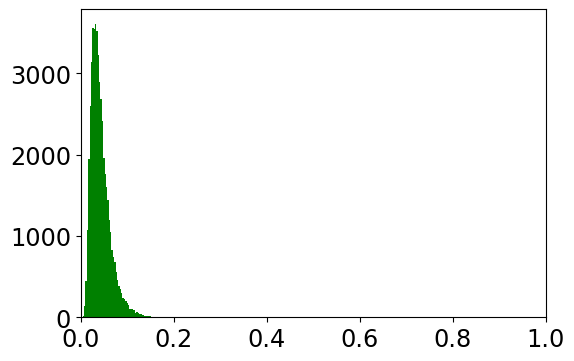

In [42]:
data_sim_vaod = np.random.lognormal(popt[1],popt[2],50000)
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(data_sim_vaod,bins=100,facecolor="g");
ax.set_xlim(0.,1.)

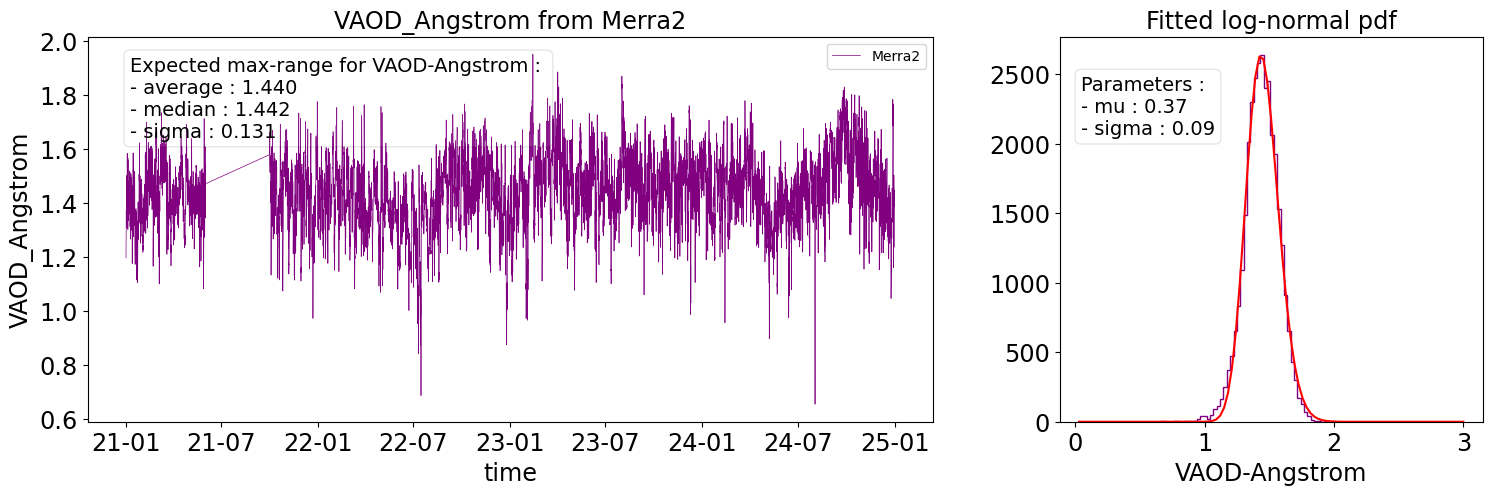

In [43]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m")

fig = plt.figure(figsize=(18,5))
gs = GridSpec(1, 2,  width_ratios=[2,1],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
        
leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.plot(pd.to_datetime(df_mb.Time.values), df_mb.TOTANGSTR.values,c="purple",lw=0.5,label="Merra2")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title("VAOD_Angstrom from Merra2")
ax1.legend()
ax1.set_ylabel("VAOD_Angstrom")
#ax.set_xlim(TMIN,TMAX)
data = df_mb.TOTANGSTR.values
mean = np.mean(data)
median = np.median(data)
std = np.std(data)
textstr = "\n".join((f"Expected max-range for VAOD-Angstrom : ",
                     f"- average : {mean:.3f}",
                     f"- median : {median:.3f}",
                     f"- sigma : {std:.3f}",     
                    ))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)



XMIN = 0.
XMAX = 3.
counts,xedges, _ = ax2.hist(df_mb.TOTANGSTR.values,bins=50,histtype="step",color="purple",ls="-",lw=3)
xcenters = (xedges[:-1] + xedges[1:]) / 2

xdata = xcenters
ydata = counts

popt, pcov = curve_fit(pdf_lognormal, xdata, ydata, p0 = [100.,1.,0.5])
sigmas = np.diag(pcov)
xfit = np.linspace(XMIN,XMAX,100)
yfit = pdf_lognormal(xfit,*popt)
ax2.plot(xfit,yfit,"-r")
textstr2 = "\n".join((f"Parameters : ",
                     f"- mu : {popt[1]:.2f}",
                     f"- sigma : {popt[2]:.2f}",     
                    ))
ax2.text(0.05, 0.9, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.set_xlabel("VAOD-Angstrom")
ax2.set_title("Fitted log-normal pdf")


figname =f"{pathfigs}/vaodangstrom_allpoints_merra2"+figtype
fig.savefig(figname)
plt.show()

(0.0, 3.0)

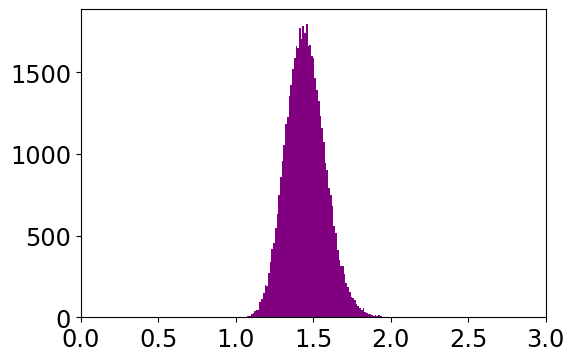

In [44]:
data_sim_angstrom = np.random.lognormal(popt[1],popt[2],50000)
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(data_sim_angstrom,bins=100,facecolor="purple");
ax.set_xlim(0.,3.)

In [45]:
all_percentiles = np.arange(0.01,1.0,0.01)
Npercentiles = len(all_percentiles)
xquantiles_pwv = [ np.quantile(data_sim_pwv, q) for q in all_percentiles]
xquantiles_o3 = [ np.quantile(data_sim_o3, q) for q in all_percentiles]
xquantiles_vaod = [ np.quantile(data_sim_vaod, q) for q in all_percentiles]
xquantiles_angstrom = [ np.quantile(data_sim_angstrom, q) for q in all_percentiles]

### Make colormaps

In [46]:
cmap = mpl.colormaps['Blues']
cmap_invert = mpl.colormaps['Blues_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_blues = np.vstack((colors1,colors2))

In [47]:
cmap = mpl.colormaps['Reds']
cmap_invert = mpl.colormaps['Reds_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_reds = np.vstack((colors1,colors2))

In [48]:
cmap = mpl.colormaps['Greens']
cmap_invert = mpl.colormaps['Greens_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_greens = np.vstack((colors1,colors2))

In [49]:
cmap = mpl.colormaps['Purples']
cmap_invert = mpl.colormaps['Purples_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_purples = np.vstack((colors1,colors2))

### Simulate transparencies

In [50]:
from getObsAtmo.getObsAtmo import ObsAtmo,validateObsName,Dict_Of_sitesPressures,getObsSiteDataFrame

In [51]:
emul =  ObsAtmo(obs_str= "LSST")
WL = emul.GetWL()

LSST site name validated as LSST observatory


## Simulate indivitual Components

In [52]:
#GetAerosolsTransparencies',
# 'GetAllTransparencies',
# 'GetGriddedTransparencies',
# 'GetO2absTransparencyArray',
# 'GetOZabsTransparencyArray',
# 'GetPWVabsTransparencyArray',
# 'GetRayleighTransparencyArray',
# 'GetWL'

## Figure showing atmospheric components without variations

(label_xt,label_yt) = (400,[0.68187378])


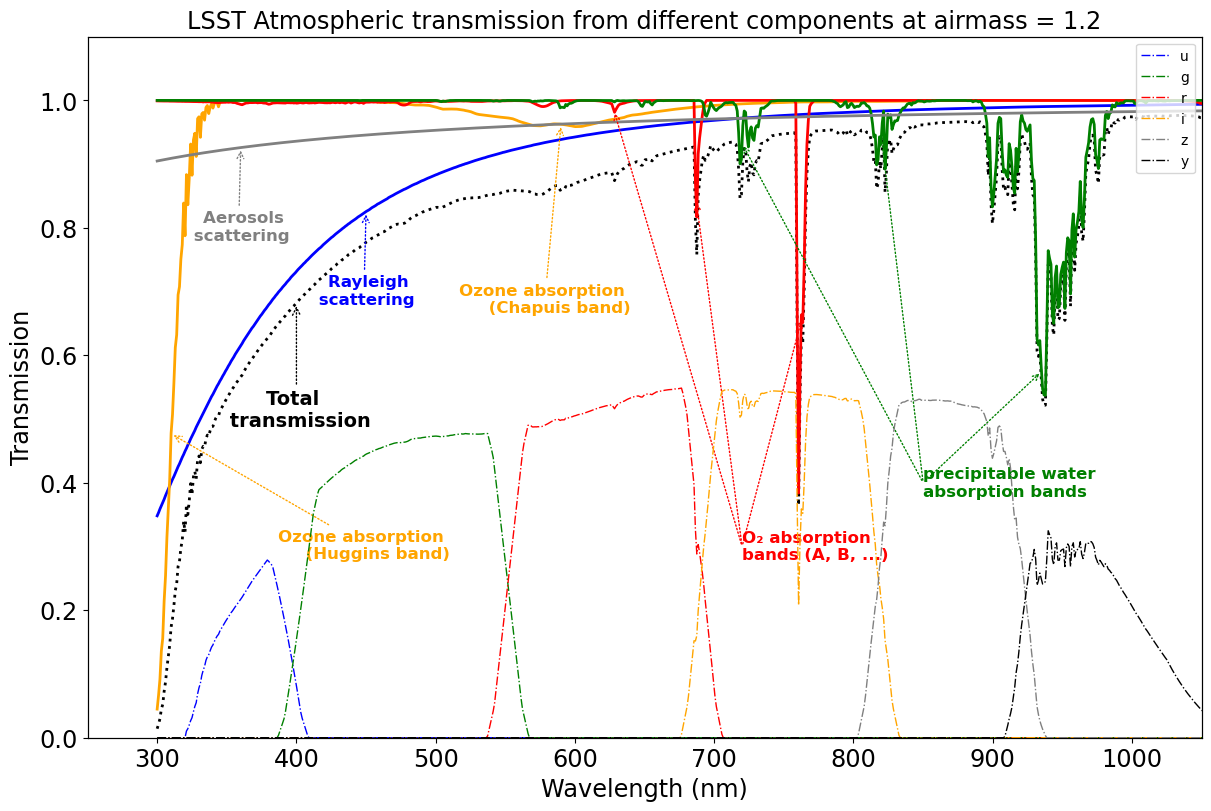

In [53]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0 = 0.04
ang0 = 1.435

fig, ax = plt.subplots(1, 1, figsize=(12, 8), layout="constrained")

# total transmission
transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang0)
ax.plot(WL,transm,":",color="k",lw=2) 


# Rayleigh scattering
transm = emul.GetRayleighTransparencyArray(WL, am0)
ax.plot(WL, transm, color="b",lw=2)

# Ozoneabsorption
transm = emul.GetOZabsTransparencyArray(WL, am0,oz0)
ax.plot(WL, transm, color="orange",lw=2)

# Oxygen 
transm = emul.GetO2absTransparencyArray(WL, am0)
ax.plot(WL, transm, color="red",lw=2)


# Precipitable water vapor
transm = emul.GetPWVabsTransparencyArray(WL, am0, pwv0)
ax.plot(WL, transm, color="green",lw=2)

# Aerosols
transm =  emul.GetAerosolsTransparencies(WL,am0,tau=vaod0,beta=ang0)
ax.plot(WL, transm, color="grey",lw=2)



# Tag Rayleigh
label_xr = 450
label_yr = emul.GetRayleighTransparencyArray(np.array([label_xr]), am0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Rayleigh \n scattering",
            xy=(label_xr, label_yr),                 # point visé par la flèche
            xytext=(label_xr + 35, label_yr - 0.15),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="b",linestyle="dotted"),
            fontsize=12,
            color="b",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')


# Tag aerosols
label_xa = 360
label_ya = emul.GetAerosolsTransparencies(np.array([label_xa]), am0,tau=vaod0,beta=ang0)[0]



# Ajouter une annotation avec une flèche
ax.annotate("Aerosols \n scattering",
            xy=(label_xa, label_ya),                 # point visé par la flèche
            xytext=(label_xa + 35, label_ya - 0.15),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="grey",linestyle="dotted"),
            fontsize=12,
            color="grey",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')

# Tag ozone
label_xo3 = 590
label_yo3 = emul.GetOZabsTransparencyArray(np.array([label_xo3]), am0,oz0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Ozone absorption \n (Chapuis band)",
            xy=(label_xo3, label_yo3),                 # point visé par la flèche
            xytext=(label_xo3 + 50, label_yo3 - 0.3),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="orange",linestyle="dotted"),
            fontsize=12,
            color="orange",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')

label_xo3b = 310
label_yo3b = emul.GetOZabsTransparencyArray(np.array([label_xo3b]), am0,oz0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Ozone absorption \n (Huggins band)",
            xy=(label_xo3b, label_yo3b),                 # point visé par la flèche
            xytext=(label_xo3b + 200, label_yo3b - 0.2),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="orange",linestyle="dotted"),
            fontsize=12,
            color="orange",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')




# Tag oxygen 
# Position des points d’absorption de l’oxygène
o2_xs = [628, 687, 763]
o2_ys = emul.GetO2absTransparencyArray(np.array(o2_xs), am0)

# Position du texte
text_x = 720
text_y = 0.3

# Annotation (texte)
ax.text(text_x, text_y, "O₂ absorption\nbands (A, B, ...)", color="red", fontsize=12,fontweight="bold",
        horizontalalignment="left", verticalalignment="center")

# Dessiner une flèche pour chaque point
for x, y in zip(o2_xs, o2_ys):
    ax.annotate("", xy=(x, y), xytext=(text_x, text_y),
                arrowprops=dict(arrowstyle="->", color="red",linestyle="dotted"))



# Tag on Precipitalbe water vapor
# Points caractéristiques d’absorption PWV
pwv_xs = [720, 820, 935]
pwv_ys = emul.GetPWVabsTransparencyArray(np.array(pwv_xs), am0, pwv0)

# Position du texte pour l’annotation
pwv_text_x = 850
pwv_text_y = 0.4

# Texte de l’étiquette
ax.text(pwv_text_x, pwv_text_y, "precipitable water\nabsorption bands", color="green", fontsize=12,fontweight="bold",
        horizontalalignment="left", verticalalignment="center")

# Flèches vers les points de la courbe
for x, y in zip(pwv_xs, pwv_ys):
    ax.annotate("", xy=(x, y), xytext=(pwv_text_x, pwv_text_y),
                arrowprops=dict(arrowstyle="->", color="green",linestyle="dotted"))


# Total transmission
label_xt = 400
label_yt = emul.GetAllTransparencies(np.array([label_xt]),am0,pwv0,oz0,tau=vaod0,beta=ang0)

print(f"(label_xt,label_yt) = ({label_xt},{label_yt})")

# Ajouter une annotation avec une flèche
ax.annotate("Total \n transmission",
            xy=(label_xt, label_yt),                 # point visé par la flèche
            xytext=(label_xt , label_yt - 0.2),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",linestyle="dotted"),
            fontsize=14,
            color="k",fontweight="bold",
            horizontalalignment='center',
            verticalalignment='bottom')


ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission")
ax.set_ylim(0.,1.1)
ax.set_xlim(250.,1050.)

title = f"LSST Atmospheric transmission from different components at airmass = {am0:.1f}"
ax.set_title(title)



axbis= ax.twinx()
for index,f in enumerate(filter_tagnames):    
    axbis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,'-.',color=filter_color[index],lw=1,label=f) 
axbis.set_ylim(0.,1.)
axbis.axes.get_yaxis().set_visible(False)
axbis.legend()



figname =f"{pathfigs}/atmtranspcomponent_predmerra2_novarition"+figtype
fig.savefig(figname)

plt.show()

360 0.9259754350103776
(label_xt,label_yt) = (400,[0.68187378])


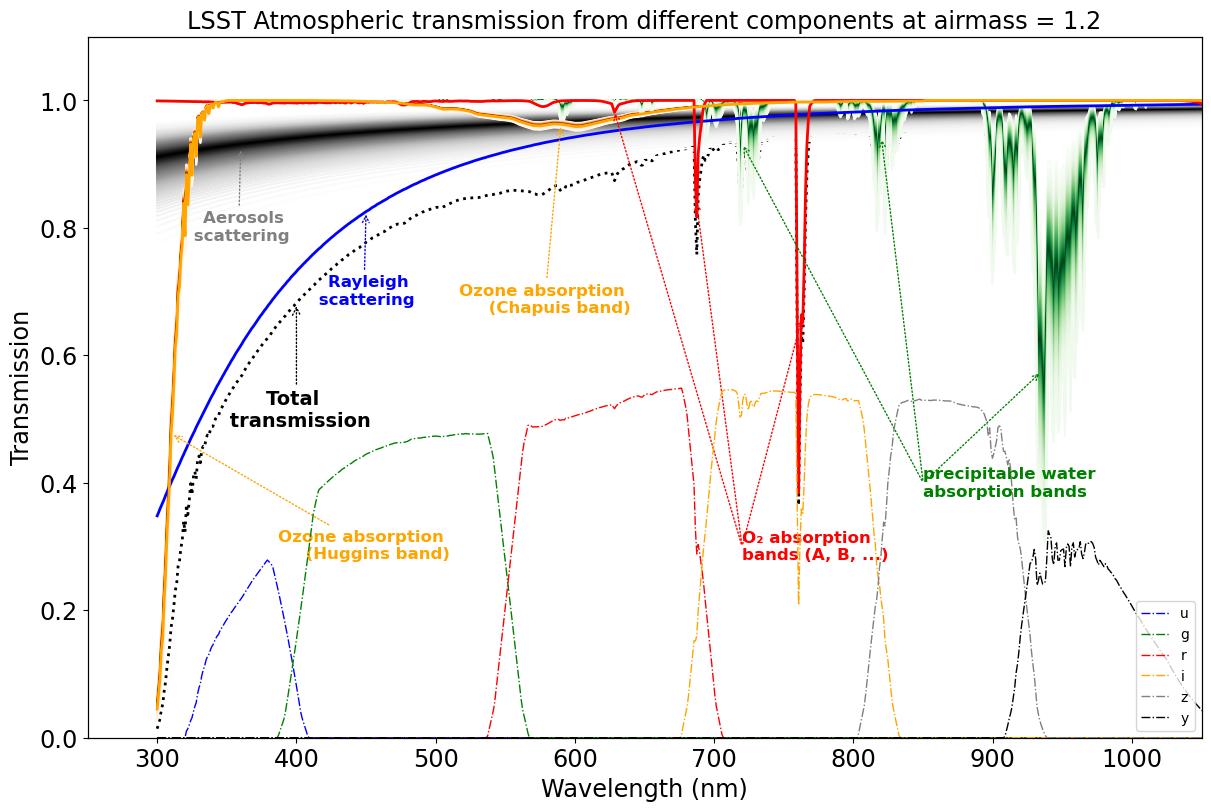

In [54]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0 = 0.04
ang0 = 1.435

fig, ax = plt.subplots(1, 1, figsize=(12, 8), layout="constrained")

# total transmission
transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang0)
ax.plot(WL,transm,":",color="k",lw=2) 


# Aerosols
cmap = mpl.colormaps['Greys']
cmap_invert = mpl.colormaps['Greys_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_greys = np.vstack((colors1,colors2))
#transm =  emul.GetAerosolsTransparencies(WL,am0,tau=vaod,beta=ang0)
#ax.plot(WL, transm, color="grey",lw=2)

for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
    transm = emul.GetAerosolsTransparencies(WL,am0,tau=vaod,beta=ang0)
    ax.plot(WL,transm,color=all_colors_greys[idx]) 
    if idx== Npercentiles//2:
        label = f"VAOD(median) = {vaod:.2f}"
        ax.plot(WL,transm,color=all_colors_greys[idx],label=label)
        transm_median = transm


# Ozoneabsorption
cmap = mpl.colormaps['Oranges']
cmap_invert = mpl.colormaps['Oranges_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_oranges = np.vstack((colors1,colors2))

#transm = emul.GetOZabsTransparencyArray(WL, am0,oz0)
#ax.plot(WL, transm, color="orange",lw=2)
for idx,quantile in enumerate(xquantiles_o3 ):
    oz = quantile
    transm = emul.GetOZabsTransparencyArray(WL, am0,oz)
    ax.plot(WL,transm,color=all_colors_oranges[idx]) 
    if idx== Npercentiles//2:
        label = f"Ozone(median) = {oz0:.2f} DU"
        ax.plot(WL,transm,color=all_colors_oranges[idx],label=label) 
        transm_median = transm



# Precipitable water vapor
#transm = emul.GetPWVabsTransparencyArray(WL, am0, pwv0)
#ax.plot(WL, transm, color="green",lw=2)

cmap = mpl.colormaps['Greens']
cmap_invert = mpl.colormaps['Greens_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_greens = np.vstack((colors1,colors2))

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_pwv ):
    pwv = quantile
    if pwv<15.0:
        transm = emul.GetPWVabsTransparencyArray(WL, am0, pwv)
        ax.plot(WL,transm,color=all_colors_greens[idx]) 
    if idx== Npercentiles//2:
        label = f"PWV(median) = {pwv:.2f} mm"
        ax.plot(WL,transm,color=all_colors_greens[idx],label=label) 
        transm_median = transm



# Rayleigh scattering
transm = emul.GetRayleighTransparencyArray(WL, am0)
ax.plot(WL, transm, color="b",lw=2)

# Oxygen 
transm = emul.GetO2absTransparencyArray(WL, am0)
ax.plot(WL, transm, color="red",lw=2)
     


# Tag Rayleigh
label_xr = 450
label_yr = emul.GetRayleighTransparencyArray(np.array([label_xr]), am0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Rayleigh \n scattering",
            xy=(label_xr, label_yr),                 # point visé par la flèche
            xytext=(label_xr + 35, label_yr - 0.15),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="b",linestyle="dotted"),
            fontsize=12,
            color="b",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')



transm = emul.GetOZabsTransparencyArray(WL, am0,oz0)
ax.plot(WL, transm, color="orange",lw=2)


# Tag aerosols
label_xa = 360
label_ya = emul.GetAerosolsTransparencies(np.array([label_xa]), am0,tau=vaod0,beta=ang0)[0]

print(label_xa,label_ya)

# Ajouter une annotation avec une flèche
ax.annotate("Aerosols \n scattering",
            xy=(label_xa, label_ya),                 # point visé par la flèche
            xytext=(label_xa + 35, label_ya - 0.15),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="grey",linestyle="dotted"),
            fontsize=12,
            color="grey",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')






# Tag ozone
label_xo3 = 590
label_yo3 = emul.GetOZabsTransparencyArray(np.array([label_xo3]), am0,oz0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Ozone absorption \n (Chapuis band)",
            xy=(label_xo3, label_yo3),                 # point visé par la flèche
            xytext=(label_xo3 + 50, label_yo3 - 0.3),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="orange",linestyle="dotted"),
            fontsize=12,
            color="orange",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')

label_xo3b = 310
label_yo3b = emul.GetOZabsTransparencyArray(np.array([label_xo3b]), am0,oz0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Ozone absorption \n (Huggins band)",
            xy=(label_xo3b, label_yo3b),                 # point visé par la flèche
            xytext=(label_xo3b + 200, label_yo3b - 0.2),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="orange",linestyle="dotted"),
            fontsize=12,
            color="orange",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')




# Tag oxygen 
# Position des points d’absorption de l’oxygène
o2_xs = [628, 687, 763]
o2_ys = emul.GetO2absTransparencyArray(np.array(o2_xs), am0)

# Position du texte
text_x = 720
text_y = 0.3

# Annotation (texte)
ax.text(text_x, text_y, "O₂ absorption\nbands (A, B, ...)", color="red", fontsize=12,fontweight="bold",
        horizontalalignment="left", verticalalignment="center")

# Dessiner une flèche pour chaque point
for x, y in zip(o2_xs, o2_ys):
    ax.annotate("", xy=(x, y), xytext=(text_x, text_y),
                arrowprops=dict(arrowstyle="->", color="red",linestyle="dotted"))



# Tag on Precipitalbe water vapor
# Points caractéristiques d’absorption PWV
pwv_xs = [720, 820, 935]
pwv_ys = emul.GetPWVabsTransparencyArray(np.array(pwv_xs), am0, pwv0)

# Position du texte pour l’annotation
pwv_text_x = 850
pwv_text_y = 0.4

# Texte de l’étiquette
ax.text(pwv_text_x, pwv_text_y, "precipitable water\nabsorption bands", color="green", fontsize=12,fontweight="bold",
        horizontalalignment="left", verticalalignment="center")

# Flèches vers les points de la courbe
for x, y in zip(pwv_xs, pwv_ys):
    ax.annotate("", xy=(x, y), xytext=(pwv_text_x, pwv_text_y),
                arrowprops=dict(arrowstyle="->", color="green",linestyle="dotted"))


# Total transmission
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0 = 0.04
ang0 = 1.435

label_xt = 400
label_yt = emul.GetAllTransparencies(np.array([label_xt]),am0,pwv0,oz0,tau=vaod0,beta=ang0)

print(f"(label_xt,label_yt) = ({label_xt},{label_yt})")

# Ajouter une annotation avec une flèche
ax.annotate("Total \n transmission",
            xy=(label_xt, label_yt),                 # point visé par la flèche
            xytext=(label_xt , label_yt - 0.2),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",linestyle="dotted"),
            fontsize=14,
            color="k",fontweight="bold",
            horizontalalignment='center',
            verticalalignment='bottom')

    

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission")
ax.set_ylim(0.,1.1)
ax.set_xlim(250.,1050.)

title = f"LSST Atmospheric transmission from different components at airmass = {am0:.1f}"
ax.set_title(title)


axbis= ax.twinx()
for index,f in enumerate(filter_tagnames):    
    axbis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,'-.',color=filter_color[index],lw=1,label=f) 
axbis.set_ylim(0.,1.)
axbis.axes.get_yaxis().set_visible(False)
axbis.legend(loc="lower right")



figname =f"{pathfigs}/atmtranspcomponent_predmerra2_variation"+figtype

fig.savefig(figname)

plt.show()

360 0.9259754350103776
(label_xt,label_yt) = (400,[0.68187378])


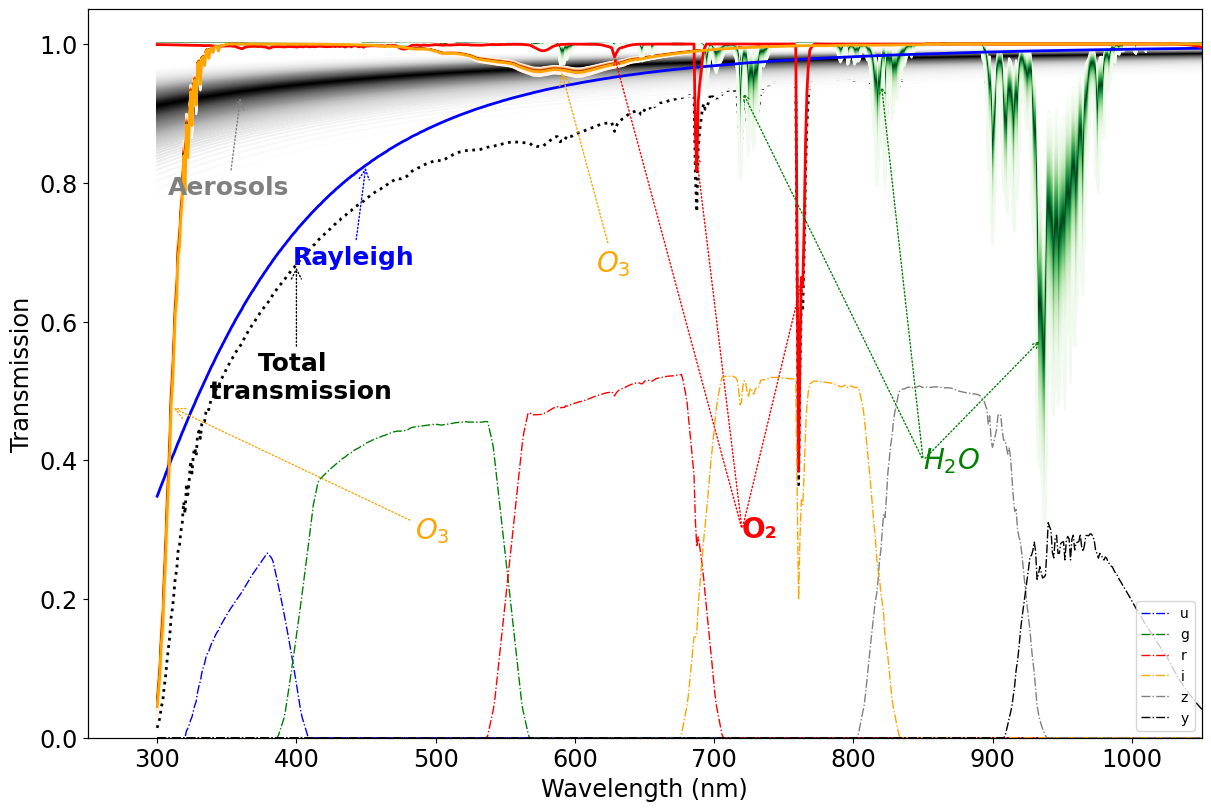

In [69]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0 = 0.04
ang0 = 1.435

fig, ax = plt.subplots(1, 1, figsize=(12, 8), layout="constrained")

# total transmission
transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang0)
ax.plot(WL,transm,":",color="k",lw=2) 


# Aerosols
cmap = mpl.colormaps['Greys']
cmap_invert = mpl.colormaps['Greys_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_greys = np.vstack((colors1,colors2))
#transm =  emul.GetAerosolsTransparencies(WL,am0,tau=vaod,beta=ang0)
#ax.plot(WL, transm, color="grey",lw=2)

for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
    transm = emul.GetAerosolsTransparencies(WL,am0,tau=vaod,beta=ang0)
    ax.plot(WL,transm,color=all_colors_greys[idx]) 
    if idx== Npercentiles//2:
        label = f"VAOD(median) = {vaod:.2f}"
        ax.plot(WL,transm,color=all_colors_greys[idx],label=label)
        transm_median = transm


# Ozoneabsorption
cmap = mpl.colormaps['Oranges']
cmap_invert = mpl.colormaps['Oranges_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_oranges = np.vstack((colors1,colors2))

#transm = emul.GetOZabsTransparencyArray(WL, am0,oz0)
#ax.plot(WL, transm, color="orange",lw=2)
for idx,quantile in enumerate(xquantiles_o3 ):
    oz = quantile
    transm = emul.GetOZabsTransparencyArray(WL, am0,oz)
    ax.plot(WL,transm,color=all_colors_oranges[idx]) 
    if idx== Npercentiles//2:
        label = f"Ozone(median) = {oz0:.2f} DU"
        ax.plot(WL,transm,color=all_colors_oranges[idx],label=label) 
        transm_median = transm



# Precipitable water vapor
#transm = emul.GetPWVabsTransparencyArray(WL, am0, pwv0)
#ax.plot(WL, transm, color="green",lw=2)

cmap = mpl.colormaps['Greens']
cmap_invert = mpl.colormaps['Greens_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_greens = np.vstack((colors1,colors2))

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_pwv ):
    pwv = quantile
    if pwv<15.0:
        transm = emul.GetPWVabsTransparencyArray(WL, am0, pwv)
        ax.plot(WL,transm,color=all_colors_greens[idx]) 
    if idx== Npercentiles//2:
        label = f"PWV(median) = {pwv:.2f} mm"
        ax.plot(WL,transm,color=all_colors_greens[idx],label=label) 
        transm_median = transm



# Rayleigh scattering
transm = emul.GetRayleighTransparencyArray(WL, am0)
ax.plot(WL, transm, color="b",lw=2)

# Oxygen 
transm = emul.GetO2absTransparencyArray(WL, am0)
ax.plot(WL, transm, color="red",lw=2)
     


# Tag Rayleigh
label_xr = 450
label_yr = emul.GetRayleighTransparencyArray(np.array([label_xr]), am0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Rayleigh",
            xy=(label_xr, label_yr),                 # point visé par la flèche
            xytext=(label_xr + 35, label_yr - 0.15),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="b",linestyle="dotted"),
            fontsize=18,
            color="b",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')



transm = emul.GetOZabsTransparencyArray(WL, am0,oz0)
ax.plot(WL, transm, color="orange",lw=2)


# Tag aerosols
label_xa = 360
label_ya = emul.GetAerosolsTransparencies(np.array([label_xa]), am0,tau=vaod0,beta=ang0)[0]

print(label_xa,label_ya)

# Ajouter une annotation avec une flèche
ax.annotate("Aerosols",
            xy=(label_xa, label_ya),                 # point visé par la flèche
            xytext=(label_xa + 35, label_ya - 0.15),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="grey",linestyle="dotted"),
            fontsize=18,
            color="grey",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')






# Tag ozone
label_xo3 = 590
label_yo3 = emul.GetOZabsTransparencyArray(np.array([label_xo3]), am0,oz0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("$O_3$",
            xy=(label_xo3, label_yo3),                 # point visé par la flèche
            xytext=(label_xo3 + 50, label_yo3 - 0.3),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="orange",linestyle="dotted"),
            fontsize=20,
            color="orange",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')

label_xo3b = 310
label_yo3b = emul.GetOZabsTransparencyArray(np.array([label_xo3b]), am0,oz0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("$O_3$",
            xy=(label_xo3b, label_yo3b),                 # point visé par la flèche
            xytext=(label_xo3b + 200, label_yo3b - 0.2),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="orange",linestyle="dotted"),
            fontsize=20,
            color="orange",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')




# Tag oxygen 
# Position des points d’absorption de l’oxygène
o2_xs = [628, 687, 763]
o2_ys = emul.GetO2absTransparencyArray(np.array(o2_xs), am0)

# Position du texte
text_x = 720
text_y = 0.3

# Annotation (texte)
ax.text(text_x, text_y, "O₂", color="red", fontsize=20,fontweight="bold",
        horizontalalignment="left", verticalalignment="center")

# Dessiner une flèche pour chaque point
for x, y in zip(o2_xs, o2_ys):
    ax.annotate("", xy=(x, y), xytext=(text_x, text_y),
                arrowprops=dict(arrowstyle="->", color="red",linestyle="dotted"))



# Tag on Precipitalbe water vapor
# Points caractéristiques d’absorption PWV
pwv_xs = [720, 820, 935]
pwv_ys = emul.GetPWVabsTransparencyArray(np.array(pwv_xs), am0, pwv0)

# Position du texte pour l’annotation
pwv_text_x = 850
pwv_text_y = 0.4

# Texte de l’étiquette
ax.text(pwv_text_x, pwv_text_y, "$H_2O$", color="green", fontsize=20,fontweight="bold",
        horizontalalignment="left", verticalalignment="center")

# Flèches vers les points de la courbe
for x, y in zip(pwv_xs, pwv_ys):
    ax.annotate("", xy=(x, y), xytext=(pwv_text_x, pwv_text_y),
                arrowprops=dict(arrowstyle="->", color="green",linestyle="dotted"))


# Total transmission
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0 = 0.04
ang0 = 1.435

label_xt = 400
label_yt = emul.GetAllTransparencies(np.array([label_xt]),am0,pwv0,oz0,tau=vaod0,beta=ang0)

print(f"(label_xt,label_yt) = ({label_xt},{label_yt})")

# Ajouter une annotation avec une flèche
ax.annotate("Total \n transmission",
            xy=(label_xt, label_yt),                 # point visé par la flèche
            xytext=(label_xt , label_yt - 0.2),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",linestyle="dotted"),
            fontsize=18,
            color="k",fontweight="bold",
            horizontalalignment='center',
            verticalalignment='bottom')

    

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission")
ax.set_ylim(0.,1.05)
ax.set_xlim(250.,1050.)

title = f"LSST Atmospheric transmission from different components at airmass = {am0:.1f}"
#ax.set_title(title)


axbis= ax.twinx()
for index,f in enumerate(filter_tagnames):    
    axbis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,'-.',color=filter_color[index],lw=1,label=f) 
axbis.set_ylim(0.,1.)
axbis.axes.get_yaxis().set_visible(False)
axbis.legend(loc="lower right")



figname =f"{pathfigs}/atmtranspcomponent_predmerra2_variation_simple"+figtype

fig.savefig(figname)

plt.show()

## Figure Transmission with Transmission Ratios

(label_xt,label_yt) = (400,[0.68187378])


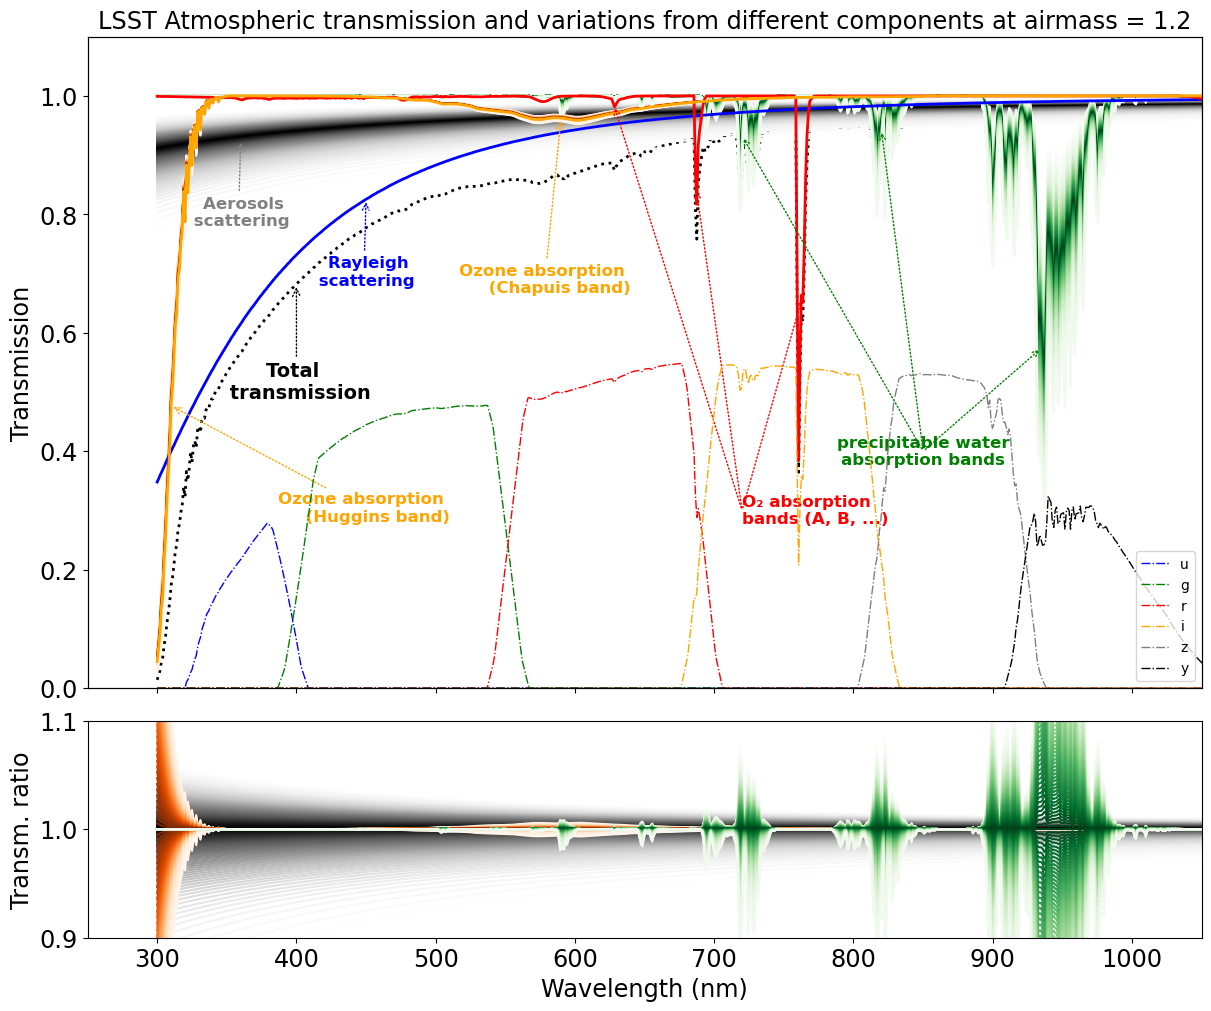

In [55]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0 = 0.04
ang0 = 1.435



fig = plt.figure(figsize=(12, 10),layout="constrained")
gs = fig.add_gridspec(2, 1  , height_ratios=(3 ,1),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.01, hspace=0.01)
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax)

# total transmission
transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang0)
ax.plot(WL,transm,":",color="k",lw=2) 


# Aerosols
cmap = mpl.colormaps['Greys']
cmap_invert = mpl.colormaps['Greys_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_greys = np.vstack((colors1,colors2))
#transm =  emul.GetAerosolsTransparencies(WL,am0,tau=vaod,beta=ang0)
#ax.plot(WL, transm, color="grey",lw=2)

for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
    transm = emul.GetAerosolsTransparencies(WL,am0,tau=vaod,beta=ang0)
    ax.plot(WL,transm,color=all_colors_greys[idx]) 
    if idx== Npercentiles//2:
        label = f"VAOD(median) = {vaod:.2f}"
        ax.plot(WL,transm,color=all_colors_greys[idx],label=label)
        transm_median = transm

#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
    transm = emul.GetAerosolsTransparencies(WL,am0,tau=vaod,beta=ang0)
    ax2.plot(WL,transm/transm_median,color=all_colors_greys[idx]) 



# Ozoneabsorption
cmap = mpl.colormaps['Oranges']
cmap_invert = mpl.colormaps['Oranges_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_oranges = np.vstack((colors1,colors2))

#transm = emul.GetOZabsTransparencyArray(WL, am0,oz0)
#ax.plot(WL, transm, color="orange",lw=2)
for idx,quantile in enumerate(xquantiles_o3 ):
    oz = quantile
    transm = emul.GetOZabsTransparencyArray(WL, am0,oz)
    ax.plot(WL,transm,color=all_colors_oranges[idx]) 
    if idx== Npercentiles//2:
        label = f"Ozone(median) = {oz0:.2f} DU"
        ax.plot(WL,transm,color=all_colors_oranges[idx],label=label) 
        transm_median = transm


for idx,quantile in enumerate(xquantiles_o3 ):
    oz = quantile
    transm = emul.GetOZabsTransparencyArray(WL, am0,oz)
    ax2.plot(WL,transm/transm_median,color=all_colors_oranges[idx]) 



# Precipitable water vapor
#transm = emul.GetPWVabsTransparencyArray(WL, am0, pwv0)
#ax.plot(WL, transm, color="green",lw=2)

cmap = mpl.colormaps['Greens']
cmap_invert = mpl.colormaps['Greens_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_greens = np.vstack((colors1,colors2))

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_pwv ):
    pwv = quantile
    if pwv<15.0:
        transm = emul.GetPWVabsTransparencyArray(WL, am0, pwv)
        ax.plot(WL,transm,color=all_colors_greens[idx]) 
    if idx== Npercentiles//2:
        label = f"PWV(median) = {pwv:.2f} mm"
        ax.plot(WL,transm,color=all_colors_greens[idx],label=label) 
        transm_median = transm

#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_pwv):
    pwv = quantile
    if pwv<15.0:
        transm = emul.GetPWVabsTransparencyArray(WL, am0, pwv)
        ax2.plot(WL,transm/transm_median,color=all_colors_greens[idx]) 



# Rayleigh scattering
transm = emul.GetRayleighTransparencyArray(WL, am0)
ax.plot(WL, transm, color="b",lw=2)



# Oxygen 
transm = emul.GetO2absTransparencyArray(WL, am0)
ax.plot(WL, transm, color="red",lw=2)

        



# Tag Rayleigh
label_xr = 450
label_yr = emul.GetRayleighTransparencyArray(np.array([label_xr]), am0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Rayleigh \n scattering",
            xy=(label_xr, label_yr),                 # point visé par la flèche
            xytext=(label_xr + 35, label_yr - 0.15),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="b",linestyle="dotted"),
            fontsize=12,
            color="b",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')



transm = emul.GetOZabsTransparencyArray(WL, am0,oz0)
ax.plot(WL, transm, color="orange",lw=2)


# Tag aerosols
label_xa = 360
label_ya = emul.GetAerosolsTransparencies(np.array([label_xa]), am0,tau=vaod0,beta=ang0)[0]


# Ajouter une annotation avec une flèche
ax.annotate("Aerosols \n scattering",
            xy=(label_xa, label_ya),                 # point visé par la flèche
            xytext=(label_xa + 35, label_ya - 0.15),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="grey",linestyle="dotted"),
            fontsize=12,
            color="grey",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')






# Tag ozone
label_xo3 = 590
label_yo3 = emul.GetOZabsTransparencyArray(np.array([label_xo3]), am0,oz0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Ozone absorption \n (Chapuis band)",
            xy=(label_xo3, label_yo3),                 # point visé par la flèche
            xytext=(label_xo3 + 50, label_yo3 - 0.3),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="orange",linestyle="dotted"),
            fontsize=12,
            color="orange",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')

label_xo3b = 310
label_yo3b = emul.GetOZabsTransparencyArray(np.array([label_xo3b]), am0,oz0)[0]
# Ajouter une annotation avec une flèche
ax.annotate("Ozone absorption \n (Huggins band)",
            xy=(label_xo3b, label_yo3b),                 # point visé par la flèche
            xytext=(label_xo3b + 200, label_yo3b - 0.2),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="orange",linestyle="dotted"),
            fontsize=12,
            color="orange",fontweight="bold",
            horizontalalignment='right',
            verticalalignment='bottom')




# Tag oxygen 
# Position des points d’absorption de l’oxygène
o2_xs = [628, 687, 763]
o2_ys = emul.GetO2absTransparencyArray(np.array(o2_xs), am0)

# Position du texte
text_x = 720
text_y = 0.3

# Annotation (texte)
ax.text(text_x, text_y, "O₂ absorption\nbands (A, B, ...)", color="red", fontsize=12,fontweight="bold",
        horizontalalignment="left", verticalalignment="center")

# Dessiner une flèche pour chaque point
for x, y in zip(o2_xs, o2_ys):
    ax.annotate("", xy=(x, y), xytext=(text_x, text_y),
                arrowprops=dict(arrowstyle="->", color="red",linestyle="dotted"))



# Tag on Precipitalbe water vapor
# Points caractéristiques d’absorption PWV
pwv_xs = [720, 820, 935]
pwv_ys = emul.GetPWVabsTransparencyArray(np.array(pwv_xs), am0, pwv0)

# Position du texte pour l’annotation
pwv_text_x = 850
pwv_text_y = 0.4

# Texte de l’étiquette
ax.text(pwv_text_x, pwv_text_y, "precipitable water\nabsorption bands", color="green", fontsize=12,fontweight="bold",
        horizontalalignment="center", verticalalignment="center")

# Flèches vers les points de la courbe
for x, y in zip(pwv_xs, pwv_ys):
    ax.annotate("", xy=(x, y), xytext=(pwv_text_x, pwv_text_y),
                arrowprops=dict(arrowstyle="->", color="green",linestyle="dotted"))


# Total transmission
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0 = 0.04
ang0 = 1.435

label_xt = 400
label_yt = emul.GetAllTransparencies(np.array([label_xt]),am0,pwv0,oz0,tau=vaod0,beta=ang0)

print(f"(label_xt,label_yt) = ({label_xt},{label_yt})")

# Ajouter une annotation avec une flèche
ax.annotate("Total \n transmission",
            xy=(label_xt, label_yt),                 # point visé par la flèche
            xytext=(label_xt , label_yt - 0.2),  # position du texte
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",linestyle="dotted"),
            fontsize=14,
            color="k",fontweight="bold",
            horizontalalignment='center',
            verticalalignment='bottom')



ax2.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission")
ax2.set_ylabel("Transm. ratio")
ax.set_ylim(0.,1.1)
ax2.set_ylim(0.9,1.1)
ax2.set_xlim(250.,1050.)

title = f"LSST Atmospheric transmission and variations from different components at airmass = {am0:.1f}"
ax.set_title(title)


axbis= ax.twinx()
for index,f in enumerate(filter_tagnames):    
    axbis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,'-.',color=filter_color[index],lw=1,label=f) 
axbis.set_ylim(0.,1.)
axbis.axes.get_yaxis().set_visible(False)
axbis.legend(loc="lower right")


plt.setp(ax.get_xticklabels(), visible=False)

figname =f"{pathfigs}/atmtranspcomponent_predmerra2_variations_ratio"+figtype
fig.savefig(figname)

plt.show()

## Plot with individual transmissions

In [56]:
cmap = mpl.colormaps['Blues']
cmap_invert = mpl.colormaps['Blues_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_blues = np.vstack((colors1,colors2))

In [57]:
cmap = mpl.colormaps['Reds']
cmap_invert = mpl.colormaps['Reds_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_reds = np.vstack((colors1,colors2))

In [58]:
cmap = mpl.colormaps['Greens']
cmap_invert = mpl.colormaps['Greens_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_greens = np.vstack((colors1,colors2))

In [59]:
cmap = mpl.colormaps['Purples']
cmap_invert = mpl.colormaps['Purples_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_purples = np.vstack((colors1,colors2))

### Transmission with PWV

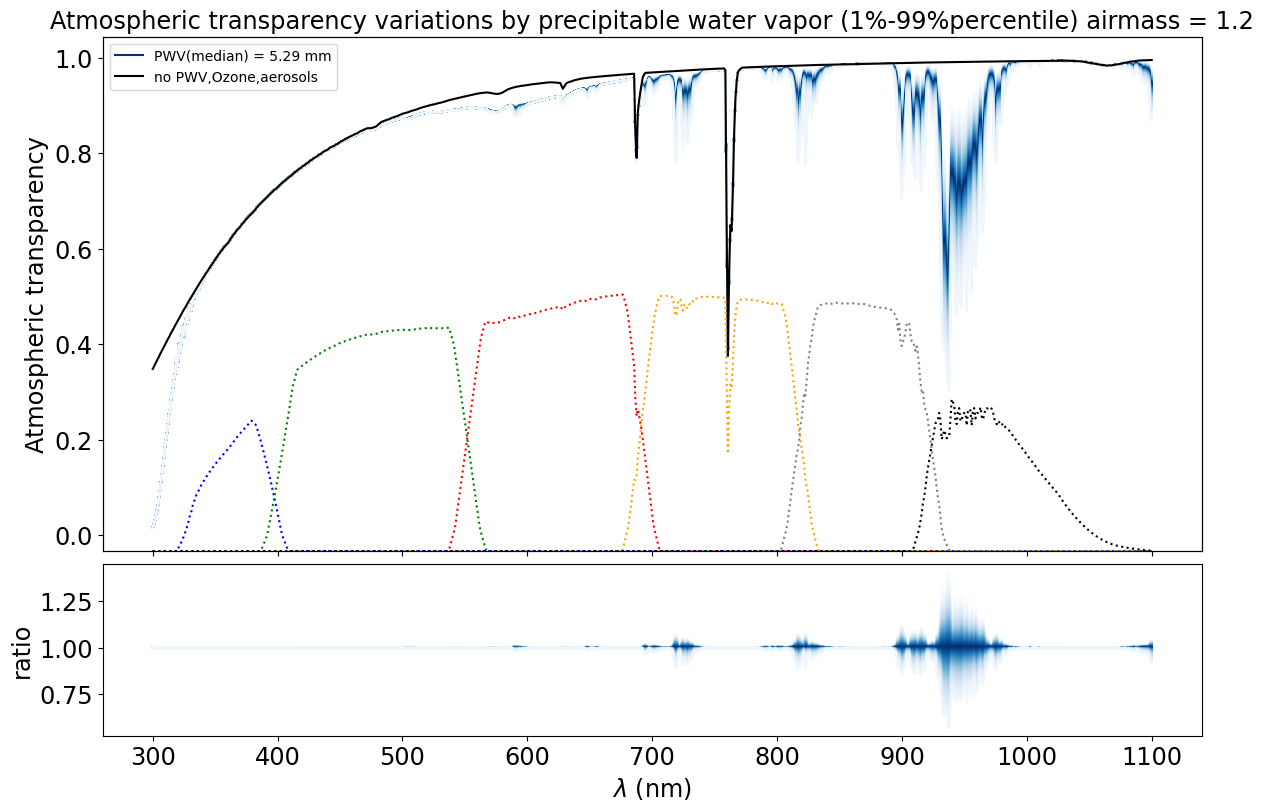

In [60]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.

fig = plt.figure(figsize=(12, 8),layout="constrained")
gs = fig.add_gridspec(2, 1  , height_ratios=(3 ,1),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.01, hspace=0.01)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_pwv ):
    pwv0 = quantile
    if pwv0<15.0:
        transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0)
        ax1.plot(WL,transm,color=all_colors_blues[idx]) 
    if idx== Npercentiles//2:
        label = f"PWV(median) = {pwv0:.2f} mm"
        ax1.plot(WL,transm,color=all_colors_blues[idx],label=label) 
        transm_median = transm

#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_pwv):
    pwv0 = quantile
    if pwv0<15.0:
        transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0)
        ax2.plot(WL,transm/transm_median,color=all_colors_blues[idx]) 

   
transm = emul.GetAllTransparencies(WL,am0,0,0,0)
ax1.plot(WL,transm,color='k',label="no PWV,Ozone,aerosols") 
ax1.set_title(f"Atmospheric transparency variations by precipitable water vapor (1%-99%percentile) airmass = {am0:.1f}")
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("ratio")
ax1.set_ylabel("Atmospheric transparency")
ax1.legend()

# band transmission    
ax1bis= ax1.twinx()
for index,f in enumerate(filter_tagnames):    
    ax1bis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
ax1bis.set_ylim(0.,1.)
ax1bis.axes.get_yaxis().set_visible(False)

plt.setp(ax1.get_xticklabels(), visible=False)

figname =f"{pathfigs}/atmtransmpwv_predmerra2"+figtype
fig.savefig(figname)

plt.show()

### Transmission with Ozone

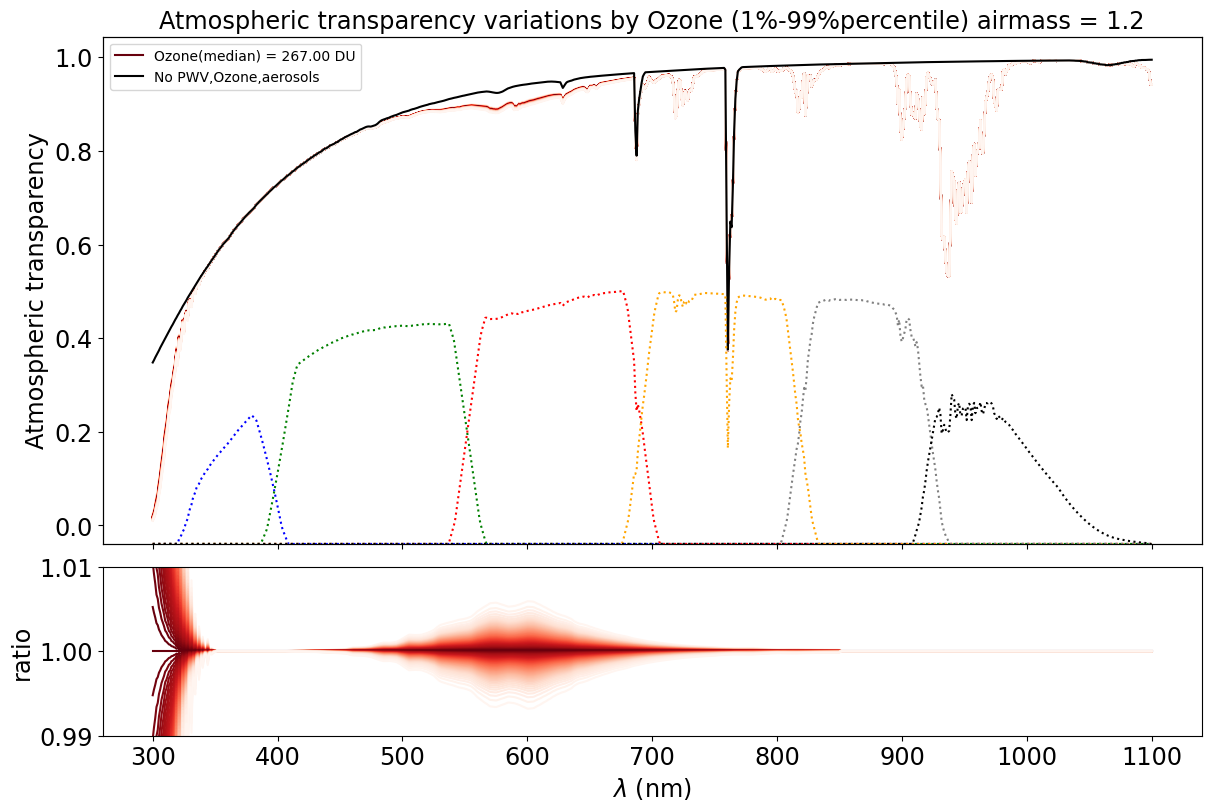

In [61]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.


fig = plt.figure(figsize=(12, 8),layout="constrained")
gs = fig.add_gridspec(2, 1  , height_ratios=(3 ,1),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.01, hspace=0.01)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_o3 ):
    oz = quantile
   
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz,0)
    ax1.plot(WL,transm,color=all_colors_reds[idx]) 
    if idx== Npercentiles//2:
        label = f"Ozone(median) = {oz0:.2f} DU"
        ax1.plot(WL,transm,color=all_colors_reds[idx],label=label) 
        transm_median = transm

#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_o3 ):
    oz = quantile
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz)
    ax2.plot(WL,transm/transm_median,color=all_colors_reds[idx]) 


transm = emul.GetAllTransparencies(WL,am0,0,0)
ax1.plot(WL,transm,color='k',label="No PWV,Ozone,aerosols") 

ax1.set_title(f"Atmospheric transparency variations by Ozone (1%-99%percentile) airmass = {am0:.1f}")
ax2.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Atmospheric transparency")
ax2.set_ylim(0.99,1.01)
ax2.set_ylabel("ratio")
ax1.legend()


# band transmission    
ax1bis= ax1.twinx()
for index,f in enumerate(filter_tagnames):    
    ax1bis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
ax1bis.set_ylim(0.,1.)
ax1bis.axes.get_yaxis().set_visible(False)


plt.setp(ax1.get_xticklabels(), visible=False)

figname =f"{pathfigs}/atmtransmozone_predmerra2"+figtype
fig.savefig(figname)


plt.show()

### Transmission with VAOD

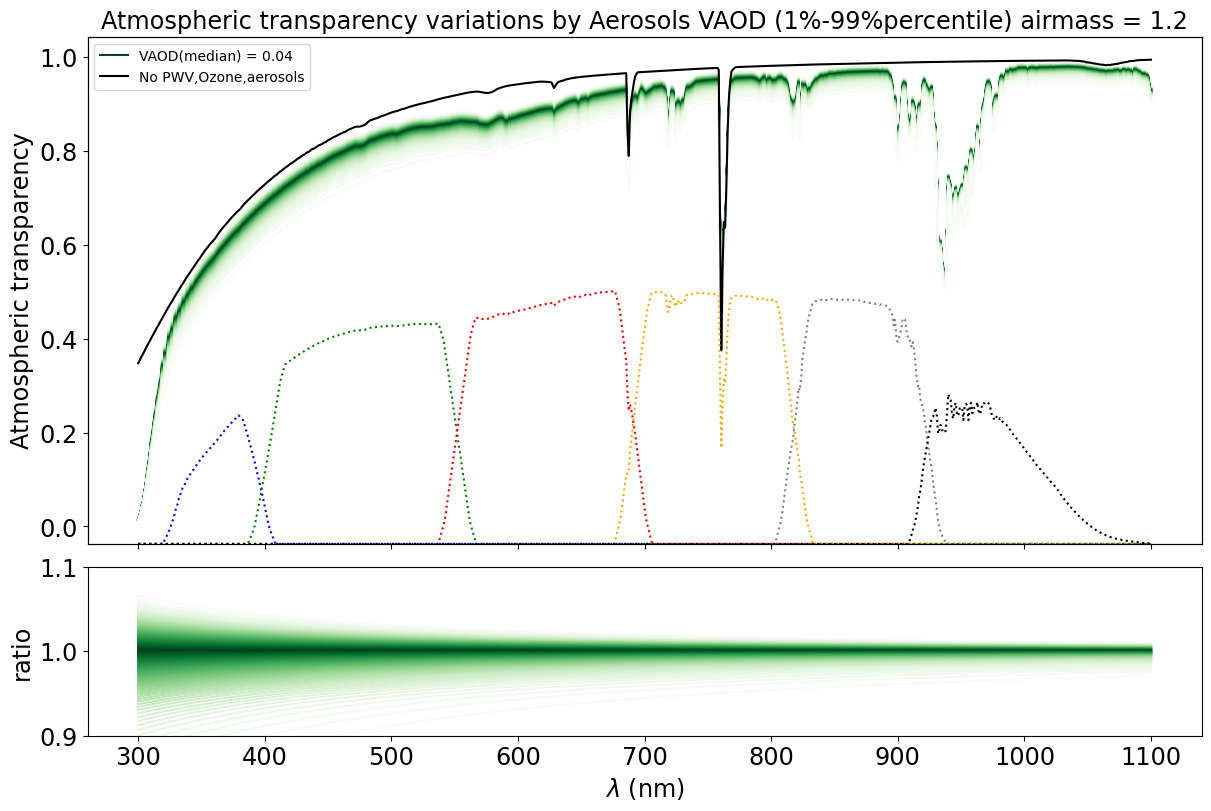

In [62]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
ang0 = 1.435


fig = plt.figure(figsize=(12, 8),layout="constrained")
gs = fig.add_gridspec(2, 1  , height_ratios=(3 ,1),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.01, hspace=0.01)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
   
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod,beta=ang0)
    ax1.plot(WL,transm,color=all_colors_greens[idx]) 
    if idx== Npercentiles//2:
        label = f"VAOD(median) = {vaod:.2f}"
        ax1.plot(WL,transm,color=all_colors_greens[idx],label=label)
        transm_median = transm
        
#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod,beta=ang0)
    ax2.plot(WL,transm/transm_median,color=all_colors_greens[idx]) 
    


transm = emul.GetAllTransparencies(WL,am0,0,0)
ax1.plot(WL,transm,color='k',label="No PWV,Ozone,aerosols") 

ax1.set_title(f"Atmospheric transparency variations by Aerosols VAOD (1%-99%percentile) airmass = {am0:.1f}")
ax2.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Atmospheric transparency")
ax1.legend()
ax2.set_ylabel("ratio")
ax2.set_ylim(0.9,1.1)

# band transmission    
ax1bis= ax1.twinx()
for index,f in enumerate(filter_tagnames):    
    ax1bis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
ax1bis.set_ylim(0.,1.)
ax1bis.axes.get_yaxis().set_visible(False)

plt.setp(ax1.get_xticklabels(), visible=False)

figname =f"{pathfigs}/atmtransmvaod_predmerra2"+figtype
fig.savefig(figname)

plt.show()

### Transmission with VAOD-Angstrom exponent

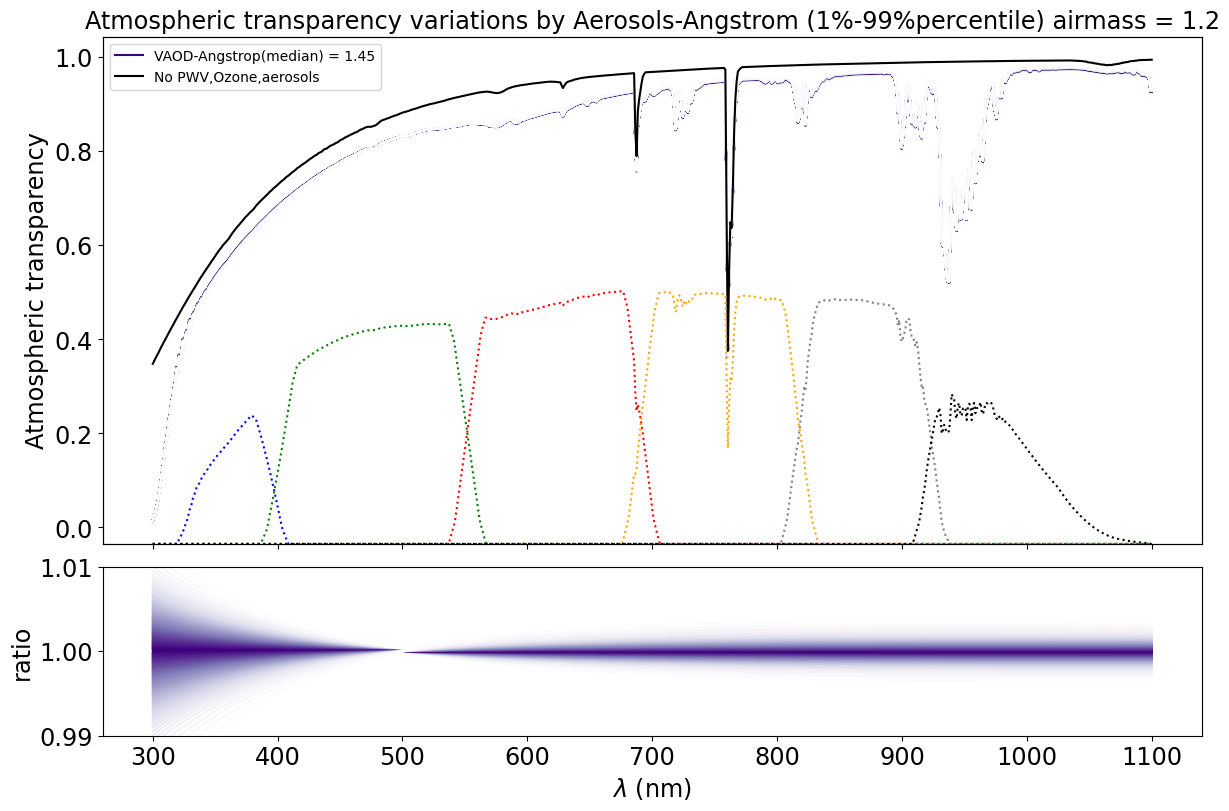

In [63]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0= 0.04

fig = plt.figure(figsize=(12, 8),layout="constrained")
gs = fig.add_gridspec(2, 1  , height_ratios=(3 ,1),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.01, hspace=0.01)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_angstrom ):
    ang = quantile
   
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang )
    ax1.plot(WL,transm,color=all_colors_purples[idx]) 
    if idx== Npercentiles//2:
        label = f"VAOD-Angstrop(median) = {ang:.2f}"
        ax1.plot(WL,transm,color=all_colors_purples[idx],label=label) 
        transm_median = transm

#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_angstrom ):
    ang = quantile
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang )
    ax2.plot(WL,transm/transm_median,color=all_colors_purples[idx]) 

transm = emul.GetAllTransparencies(WL,am0,0,0)
ax1.plot(WL,transm,color='k',label="No PWV,Ozone,aerosols") 
ax1.set_title(f"Atmospheric transparency variations by Aerosols-Angstrom (1%-99%percentile) airmass = {am0:.1f}")
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylim(0.99,1.01)
ax1.set_ylabel("Atmospheric transparency")
ax1.legend()
ax2.set_ylabel("ratio")

# band transmission    
ax1bis= ax1.twinx()
for index,f in enumerate(filter_tagnames):    
    ax1bis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
ax1bis.set_ylim(0.,1.)
ax1bis.axes.get_yaxis().set_visible(False)

plt.setp(ax1.get_xticklabels(), visible=False)


figname =f"{pathfigs}/atmtransmangstrom_predmerra2"+figtype
fig.savefig(figname)

plt.show()

### Combined transmission without ratio

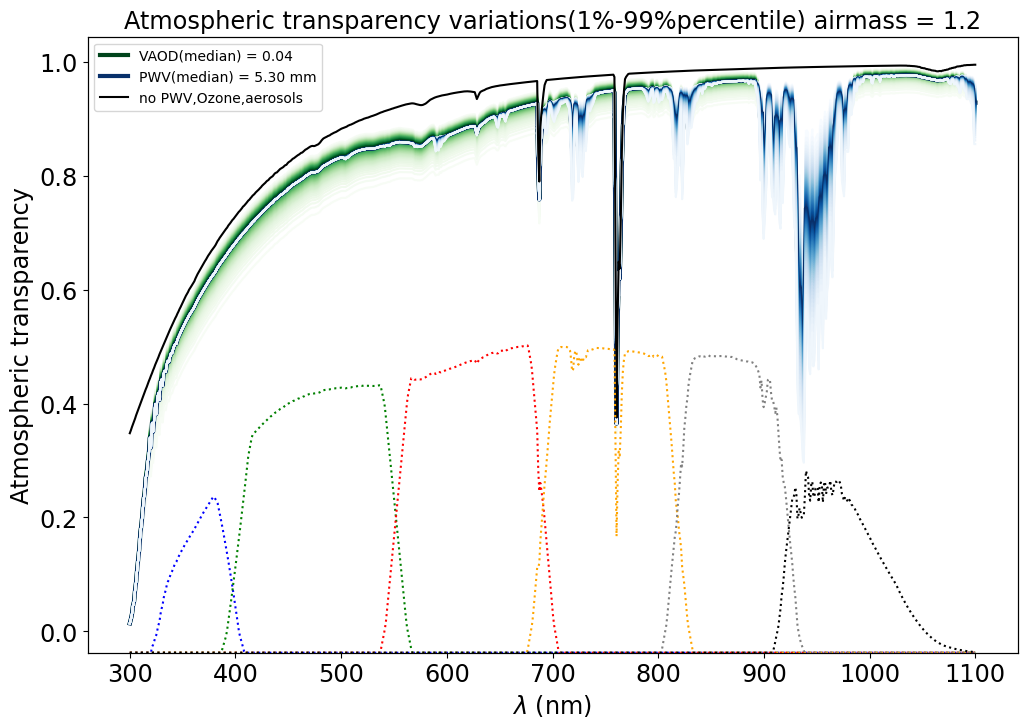

In [64]:
fig, ax = plt.subplots(1,1,figsize=(12,8))


am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0= 0.04
ang0 = 1.435


# Ozone
#for idx,quantile in enumerate(xquantiles_o3):
#    oz = quantile  
#    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz,vaod0,ang0)
#    ax.plot(WL,transm,color=all_colors_reds[idx]) 
#    if idx== Npercentiles//2:
#        label = f"Ozone(median) = {oz0:.2f} DU"
#        ax.plot(WL,transm,color=all_colors_reds[idx],label=label,lw=3) 


# Angstrom
#for idx,quantile in enumerate(xquantiles_angstrom):
#    ang = quantile   
#    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang )
#    ax.plot(WL,transm,color=all_colors_purples[idx]) 
#    if idx== Npercentiles//2:
#        label = f"VAOD-Angstrop(median) = {ang:.2f}"
#        ax.plot(WL,transm,color=all_colors_purples[idx],label=label,lw=3) 

#atmospheric transmission

#VAOD
for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
   
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod,beta=ang0)
    ax.plot(WL,transm,color=all_colors_greens[idx]) 
    if idx== Npercentiles//2:
        label = f"VAOD(median) = {vaod:.2f}"
        ax.plot(WL,transm,color=all_colors_greens[idx],label=label,lw=3) 

# PWV
for idx,quantile in enumerate(xquantiles_pwv):
    pwv = quantile
    if pwv<15.0:
        transm = emul.GetAllTransparencies(WL,am0,pwv,oz0,vaod0,ang0)
        ax.plot(WL,transm,color=all_colors_blues[idx]) 
    if idx== Npercentiles//2:
        label = f"PWV(median) = {pwv0:.2f} mm"
        ax.plot(WL,transm,color=all_colors_blues[idx],label=label,lw=3) 



        
transm = emul.GetAllTransparencies(WL,am0,0,0,0)
ax.plot(WL,transm,color='k',label="no PWV,Ozone,aerosols") 

ax.set_title(f"Atmospheric transparency variations(1%-99%percentile) airmass = {am0:.1f}")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("Atmospheric transparency")
ax.legend()

# band transmission    
axbis= ax.twinx()
for index,f in enumerate(filter_tagnames):    
    axbis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
axbis.set_ylim(0.,1.)
axbis.axes.get_yaxis().set_visible(False)


figname =f"{pathfigs}/atmtransmpwvvaodcombined_predmerra2"+figtype
fig.savefig(figname)


plt.show()